In [1]:
#### Import dependencies
import face_functions as ff

import os, sys
import cv2
from PIL import Image
import numpy as np
import pickle
import time
import matplotlib.pyplot as plt
import scipy
from scipy import linalg
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import tensorflow as tf
import keras
from keras_vggface.vggface import VGGFace
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras_vggface import utils
%matplotlib inline

Using TensorFlow backend.


In [4]:
def get_faces_labels(resized_images_path='Color_Faces'):
    file_path = os.listdir(resized_images_path)
    faces = []
    face_labels = []
    current_id=0
    label_ids={}
    for file in file_path:
        if file.endswith("png") or file.endswith("jpg"):
            path=os.path.join(resized_images_path, file)
            label=os.path.basename(path).split(".")[1]
            #print(label,path)
            if not label in label_ids:
                #label_ids[label] = os.path.basename(path).split(".")[2]
                label_ids[label]=current_id
                current_id+=1

            id_=label_ids[label]
            pil_image=Image.open(path)#grayscale
            image_array=np.array(pil_image,'uint8')
                           
            #print(image_array)
            faces.append(image_array)
            face_labels.append(id_)
            faces_array = np.array(faces)
            labels_array = np.array(face_labels)
    return faces_array, labels_array, label_ids

In [28]:
face1d, labels, label_dict = get_faces_labels()
print(face1d.shape)
print(face1d.shape[0])
print(labels)
print(label_dict)

(5, 100, 100, 3)
5
[0 0 0 0 0]
{'yirong': 0}


In [29]:
print(face1d[0].shape)

(100, 100, 3)


In [32]:
face = cv2.resize(face1d[0], (224,224))

In [33]:
face.shape

(224, 224, 3)

In [38]:
face is face1d[0]

False

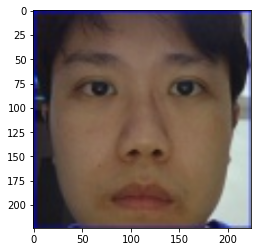

In [39]:
plt.imshow(face)

In [3]:
def reshape_face(face2d):
    face_rgb = []
    for i in face2d:
        face_resize = cv2.resize(i, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
        face_color = cv2.cvtColor(face_resize, cv2.COLOR_GRAY2RGB)
        face_rgb.append(face_color)
        face_rgb_array = np.array(face_rgb)
    
    return face_rgb_array

(50, 224, 224, 3)


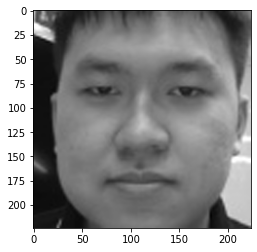

In [4]:
face_rgb_array = reshape_face(face1d)
print(face_rgb_array.shape)
plt.imshow(face_rgb_array[0])

In [13]:
# Based on VGG16 architecture -> old paper(2015)
vggface = VGGFace(model='vgg16') # or VGGFace() as default

# Based on RESNET50 architecture -> new paper(2017)
#vggface = VGGFace(model='resnet50')

# Based on SENET50 architecture -> new paper(2017)
#vggface = VGGFace(model='senet50')

In [14]:
vggface.summary()

Model: "vggface_vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)     

In [29]:
from keras.engine import  Model
from keras.layers import Flatten, Dense, Input
from keras_vggface.vggface import VGGFace

#custom parameters
nb_class = 10

vgg_model = VGGFace(include_top=True, input_shape=(224, 224, 3))
last_layer = vgg_model.get_layer('fc8').output
out = Dense(nb_class, activation='softmax', name='softmax')(last_layer)
custom_vgg_model = Model(vgg_model.input, last_layer)
for layer in custom_vgg_model.layers[:-1]:
    layer.trainable = False
custom_vgg_model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)       0   

In [26]:
from keras.utils import to_categorical
# one hot encode
encoded_label = to_categorical(labels)
print(encoded_label.shape)

(50, 10)


In [30]:
# Compile the model
tf.random.set_seed(1234)
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
custom_vgg_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks list
filepath = 'vggface_170321.hdf5'
callbacks_list = [ModelCheckpoint(filepath=filepath, monitor='loss', verbose=1, save_best_only=True)]

# Train model
batch_size = 8
epochs = 10


history = custom_vgg_model.fit(face_rgb_array, encoded_label, batch_size=batch_size, epochs=epochs, verbose=1, callbacks=callbacks_list)

Epoch 1/10
50/50 [==============================] - 8s 158ms/step - loss: 5.7882 - accuracy: 0.2200

Epoch 00001: loss improved from inf to 5.78824, saving model to vggface_170321.hdf5


C:\Users\Yirong\miniconda3\envs\python36_vggface\lib\site-packages\keras\engine\saving.py:165: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '


Epoch 2/10
50/50 [==============================] - 8s 151ms/step - loss: 0.9439 - accuracy: 0.6800

Epoch 00002: loss improved from 5.78824 to 0.94393, saving model to vggface_170321.hdf5
Epoch 3/10
50/50 [==============================] - 7s 147ms/step - loss: 0.4089 - accuracy: 0.8800

Epoch 00003: loss improved from 0.94393 to 0.40890, saving model to vggface_170321.hdf5
Epoch 4/10
50/50 [==============================] - 8s 150ms/step - loss: 0.0318 - accuracy: 0.9800

Epoch 00004: loss improved from 0.40890 to 0.03176, saving model to vggface_170321.hdf5
Epoch 5/10
50/50 [==============================] - 8s 156ms/step - loss: 0.0012 - accuracy: 1.0000

Epoch 00005: loss improved from 0.03176 to 0.00120, saving model to vggface_170321.hdf5
Epoch 6/10
50/50 [==============================] - 11s 228ms/step - loss: 0.0035 - accuracy: 1.0000

Epoch 00006: loss did not improve from 0.00120
Epoch 7/10
50/50 [==============================] - 14s 280ms/step - loss: 0.0035 - accuracy: 1

In [5]:
# Real Time Detection using SVM
def vgg_face_recognition():
    faceCascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml') # load classifier
    eye_glassesCascade = cv2.CascadeClassifier('haarcascade_eye_tree_eyeglasses.xml')
    
    # Load trained model
    vgg_model = load_model('vggface_170321.hdf5')
    tf.random.set_seed(1234)
    opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    vgg_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

    cap = cv2.VideoCapture(0)

    names = ['Bryan_Lee', 'Bryan_Lim', 'Edmund', 'Malvern', 'Peter', 'Ter_Ren', 
             'Wang_Jue', 'Yi_Cheng', 'Yi_Rong', 'Zi_Ying']
    cap.set(3,640) # set Width
    cap.set(4,480) # set Height
    while True:
        _, frame = cap.read()
        frame = cv2.flip(frame, 1)
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # detect faces
        faces = faceCascade.detectMultiScale(
            gray,     
            scaleFactor=1.2,
            minNeighbors=5,     
            minSize=(5, 5)
        )
        for (x,y,w,h) in faces:
            cv2.rectangle(frame,(x,y),(x+w,y+h),(255,0,0),2)
            roi_color = frame[y:y+h, x:x+w]
            roi_gray = gray[y:y+h, x:x+w]
    #        roi_gray = cv2.resize(roi_gray, (100,100))
            eyes = eye_glassesCascade.detectMultiScale(roi_gray, scaleFactor=1.2, minNeighbors=5, minSize=(5,5))
            for (ex, ey, ew, eh) in eyes:
                cv2.rectangle(roi_color, (ex, ey), (ex + ew, ey + eh), (0, 255, 0), 2)
    #         smile = smileCascade.detectMultiScale(roi_gray, scaleFactor=1.2, minNeighbors=25, minSize=(120,120))
    #         for (xx, yy, ww, hh) in smile:
    #             cv2.rectangle(roi_color, (xx, yy), (xx + ww, yy + hh), (0, 0, 255), 2)
            gray_face = cv2.resize((gray[y:y+h,x:x+w]),(100,100))
            #gray_face_1d = gray_face.reshape(1,-1)
            rgb_face = reshape_face(gray_face)
            #x = utils.preprocess_input(rgb_face, version=1) # or version=2
            y_pred = vgg_model.predict(rgb_face)
            #top_prob = max(y_pred)
            #top_prob_name = names[np.argmax(y_pred)]
            #top_prob = y_pred[:,np.argmax(y_pred)]
            #print(y_pred)
            #print(top_prob)
            
            #text = str(y_pred[0]) + ':' + names[int(y_pred[0])]
            text = str(y_pred)
            cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 0, 0), 2)
            cv2.putText(frame, text, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)
            
        cv2.imshow('frame',frame)
        k = cv2.waitKey(1) & 0xff
        if k == 27: # press 'ESC' to quit
            break
    cap.release()
    cv2.destroyAllWindows()

In [6]:
vgg_face_recognition()

C:\Users\Yirong\miniconda3\envs\python36_vggface\lib\site-packages\keras\engine\saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


IndexError: list index out of range

In [110]:
pca_face_recognition(t,w)

[[0.04108192 0.20766731 0.0419647  0.03775013 0.02104595 0.04820611
  0.03362468 0.28470515 0.0696462  0.21430785]]
[[0.03894916 0.14584786 0.04310042 0.0384119  0.02775582 0.06415608
  0.05520997 0.20311879 0.0919308  0.2915192 ]]
[[0.04399259 0.18571706 0.044395   0.04138237 0.02231918 0.05382233
  0.03885914 0.22569427 0.06809949 0.27571856]]
[[0.04298086 0.19076984 0.04919096 0.04399076 0.02375741 0.05844159
  0.03973468 0.23162367 0.06517488 0.25433535]]
[[0.04059714 0.19988933 0.04887057 0.03836742 0.02627747 0.0656391
  0.05101948 0.24411654 0.07724443 0.20797851]]
[[0.04115852 0.129712   0.04588654 0.04137678 0.02812703 0.06646483
  0.05184879 0.17546127 0.10461029 0.31535395]]
[[0.05501031 0.17950274 0.0771178  0.04873784 0.03431182 0.10752108
  0.0723184  0.24548104 0.07671599 0.10328297]]
[[0.04881765 0.20044718 0.06216702 0.05121053 0.02523171 0.073345
  0.03874566 0.27614366 0.06829101 0.15560059]]
[[0.03835442 0.17632951 0.05660363 0.04820812 0.02536089 0.05682316
  0.059

[[0.03526638 0.25384132 0.03179532 0.02929293 0.01835426 0.03992194
  0.02268151 0.30522194 0.11659624 0.14702816]]
[[0.03536968 0.25985398 0.03086835 0.02944595 0.01878791 0.04099345
  0.02157674 0.31945645 0.1062204  0.13742708]]
[[0.03472382 0.24668748 0.03322198 0.02957529 0.02050481 0.04250622
  0.02472782 0.29593185 0.12344456 0.14867619]]
[[0.03529062 0.24336813 0.02978405 0.02810113 0.01970199 0.04168057
  0.02271948 0.32150962 0.10829882 0.14954558]]
[[0.04018648 0.25028321 0.03291016 0.03095667 0.01822182 0.03977434
  0.02247611 0.26209693 0.10115043 0.20194384]]
[[0.03957442 0.24285503 0.02994364 0.02962496 0.01867984 0.04306271
  0.02005644 0.29548414 0.08661898 0.19409984]]
[[0.04019109 0.24928023 0.0310353  0.03196741 0.01792902 0.0422618
  0.02002161 0.28899644 0.08393473 0.19438237]]
[[0.03574725 0.25733016 0.03777873 0.04447767 0.01967927 0.06338369
  0.0182349  0.30591329 0.07022885 0.14722619]]
[[0.03483391 0.27611631 0.03279883 0.03540985 0.01721393 0.04487263
  0.0

In [42]:
pca_face_recognition(a,pca.components_.T)

[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.05960589 0.12610872 0.06512315 0.08398761]]
[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.05960589 0.12610872 0.06512315 0.08398761]]
[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.05960589 0.12610872 0.06512315 0.08398761]]
[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.05960589 0.12610872 0.06512315 0.08398761]]
[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.05960589 0.12610872 0.06512315 0.08398761]]
[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.05960589 0.12610872 0.06512315 0.08398761]]
[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.05960589 0.12610872 0.06512315 0.08398761]]
[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.05960589 0.12610872 0.06512315 0.08398761]]
[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.

[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.05960589 0.12610872 0.06512315 0.08398761]]
[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.05960589 0.12610872 0.06512315 0.08398761]]
[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.05960589 0.12610872 0.06512315 0.08398761]]
[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.05960589 0.12610872 0.06512315 0.08398761]]
[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.05960589 0.12610872 0.06512315 0.08398761]]
[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.05960589 0.12610872 0.06512315 0.08398761]]
[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.05960589 0.12610872 0.06512315 0.08398761]]
[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.05960589 0.12610872 0.06512315 0.08398761]]
[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.

[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.05960589 0.12610872 0.06512315 0.08398761]]
[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.05960589 0.12610872 0.06512315 0.08398761]]
[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.05960589 0.12610872 0.06512315 0.08398761]]
[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.05960589 0.12610872 0.06512315 0.08398761]]
[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.05960589 0.12610872 0.06512315 0.08398761]]
[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.05960589 0.12610872 0.06512315 0.08398761]]
[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.05960589 0.12610872 0.06512315 0.08398761]]
[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.05960589 0.12610872 0.06512315 0.08398761]]
[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.

[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.05960589 0.12610872 0.06512315 0.08398761]]
[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.05960589 0.12610872 0.06512315 0.08398761]]
[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.05960589 0.12610872 0.06512315 0.08398761]]
[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.05960589 0.12610872 0.06512315 0.08398761]]
[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.05960589 0.12610872 0.06512315 0.08398761]]
[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.05960589 0.12610872 0.06512315 0.08398761]]
[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.05960589 0.12610872 0.06512315 0.08398761]]
[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.05960589 0.12610872 0.06512315 0.08398761]]
[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.

[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.05960589 0.12610872 0.06512315 0.08398761]]
[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.05960589 0.12610872 0.06512315 0.08398761]]
[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.05960589 0.12610872 0.06512315 0.08398761]]
[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.05960589 0.12610872 0.06512315 0.08398761]]
[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.05960589 0.12610872 0.06512315 0.08398761]]
[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.05960589 0.12610872 0.06512315 0.08398761]]
[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.05960589 0.12610872 0.06512315 0.08398761]]
[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.05960589 0.12610872 0.06512315 0.08398761]]
[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.

[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.05960589 0.12610872 0.06512315 0.08398761]]
[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.05960589 0.12610872 0.06512315 0.08398761]]
[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.05960589 0.12610872 0.06512315 0.08398761]]
[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.05960589 0.12610872 0.06512315 0.08398761]]
[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.05960589 0.12610872 0.06512315 0.08398761]]
[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.05960589 0.12610872 0.06512315 0.08398761]]
[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.05960589 0.12610872 0.06512315 0.08398761]]
[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.05960589 0.12610872 0.06512315 0.08398761]]
[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.

[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.05960589 0.12610872 0.06512315 0.08398761]]
[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.05960589 0.12610872 0.06512315 0.08398761]]
[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.05960589 0.12610872 0.06512315 0.08398761]]
[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.05960589 0.12610872 0.06512315 0.08398761]]
[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.05960589 0.12610872 0.06512315 0.08398761]]
[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.05960589 0.12610872 0.06512315 0.08398761]]
[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.05960589 0.12610872 0.06512315 0.08398761]]
[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.05960589 0.12610872 0.06512315 0.08398761]]
[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.

[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.05960589 0.12610872 0.06512315 0.08398761]]
[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.05960589 0.12610872 0.06512315 0.08398761]]
[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.05960589 0.12610872 0.06512315 0.08398761]]
[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.05960589 0.12610872 0.06512315 0.08398761]]
[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.05960589 0.12610872 0.06512315 0.08398761]]
[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.05960589 0.12610872 0.06512315 0.08398761]]
[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.05960589 0.12610872 0.06512315 0.08398761]]
[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.05960589 0.12610872 0.06512315 0.08398761]]
[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.

[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.05960589 0.12610872 0.06512315 0.08398761]]
[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.05960589 0.12610872 0.06512315 0.08398761]]
[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.05960589 0.12610872 0.06512315 0.08398761]]
[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.05960589 0.12610872 0.06512315 0.08398761]]
[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.05960589 0.12610872 0.06512315 0.08398761]]
[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.05960589 0.12610872 0.06512315 0.08398761]]
[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.05960589 0.12610872 0.06512315 0.08398761]]
[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.05960589 0.12610872 0.06512315 0.08398761]]
[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.

# VGGFACE 18/03

In [10]:
face1d, labels, label_dict = ff.get_faces_labels()
print(face1d.shape)
print(face1d.shape[0])
print(labels)
print(label_dict)

(50, 100, 100)
50
[0 0 0 0 0 1 1 1 1 1 2 2 2 2 2 3 3 3 3 3 4 4 4 4 4 5 5 5 5 5 6 6 6 6 6 7 7
 7 7 7 8 8 8 8 8 9 9 9 9 9]
{'bryan_lee': 0, 'bryan_lim': 1, 'edmund': 2, 'malvern': 3, 'peter': 4, 'terren': 5, 'wangjue': 6, 'yicheng': 7, 'yirong': 8, 'ziying': 9}


In [11]:
def reshape_face(face2d):
    face_rgb = []
    for i in face2d:
        face_resize = cv2.resize(i, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
        face_color = cv2.cvtColor(face_resize, cv2.COLOR_GRAY2RGB)
        face_rgb.append(face_color)
        face_rgb_array = np.array(face_rgb)
    
    return face_rgb_array

(50, 224, 224, 3)


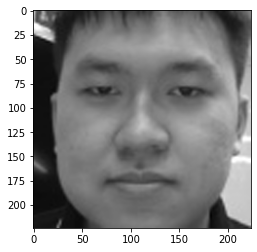

In [12]:
face_rgb_array = reshape_face(face1d)
print(face_rgb_array.shape)
plt.imshow(face_rgb_array[0])

In [13]:
from keras.engine import  Model
from keras.layers import Flatten, Dense, Input
from keras_vggface.vggface import VGGFace

vgg_model = VGGFace(include_top=True, input_shape=(224, 224, 3))
last_layer = vgg_model.get_layer('fc8').output
custom_vgg_model = Model(vgg_model.input, last_layer)

custom_vgg_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)       0   

In [14]:
representation = custom_vgg_model.predict(face_rgb_array)
print(representation.shape)

(50, 2622)


In [15]:
names = ['Bryan_Lee', 'Bryan_Lim', 'Edmund', 'Malvern', 'Peter', 'Ter_Ren', 
         'Wang_Jue', 'Yi_Cheng', 'Yi_Rong', 'Zi_Ying']
name_list = []
for i in range(len(names)):
    for j in range(5):
        name = names[i]
        name_list.append(name)
name_array = np.array(name_list)
print(len(name_list))
print(name_array.shape)

50
(50,)


In [16]:
def findCosineSimilarity(source, test):
    a = np.matmul(np.transpose(source), test)
    b = np.sum(np.multiply(source, source))
    c = np.sum(np.multiply(test, test))
    return 1 - (a / (np.sqrt(b) * np.sqrt(c)))

In [18]:
dist = findCosineSimilarity(representation[44], representation[41])
print(dist)

0.13296544551849365


In [22]:
def vgg_face_recognition(name_array, representation):
    faceCascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml') # load classifier
    eye_glassesCascade = cv2.CascadeClassifier('haarcascade_eye_tree_eyeglasses.xml')

    cap = cv2.VideoCapture(0)

    cap.set(3,640) # set Width
    cap.set(4,480) # set Height
    while True:
        _, frame = cap.read()
        frame = cv2.flip(frame, 1)
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # detect faces
        faces = faceCascade.detectMultiScale(
            gray,     
            scaleFactor=1.2,
            minNeighbors=5,     
            minSize=(5, 5)
        )
        for (x,y,w,h) in faces:
            cv2.rectangle(frame,(x,y),(x+w,y+h),(255,0,0),2)
            roi_color = frame[y:y+h, x:x+w]
            roi_gray = gray[y:y+h, x:x+w]
    #        roi_gray = cv2.resize(roi_gray, (100,100))
            eyes = eye_glassesCascade.detectMultiScale(roi_gray, scaleFactor=1.2, minNeighbors=5, minSize=(5,5))
            for (ex, ey, ew, eh) in eyes:
                cv2.rectangle(roi_color, (ex, ey), (ex + ew, ey + eh), (0, 255, 0), 2)
    #         smile = smileCascade.detectMultiScale(roi_gray, scaleFactor=1.2, minNeighbors=25, minSize=(120,120))
    #         for (xx, yy, ww, hh) in smile:
    #             cv2.rectangle(roi_color, (xx, yy), (xx + ww, yy + hh), (0, 0, 255), 2)
            gray_face = cv2.resize((gray[y:y+h,x:x+w]),(224,224))
            rgb_face = cv2.cvtColor(gray_face, cv2.COLOR_GRAY2RGB)
            rgb_face_resize = np.reshape(rgb_face, (1,224,224,3))
            y_pred = custom_vgg_model.predict(rgb_face_resize)
            captured_representation = np.transpose(y_pred)
            
            
            found = 0
            min_value=1
            for i in range(len(name_array)):
                similarity = findCosineSimilarity(representation[i], captured_representation)
                if((similarity < 0.2) & (similarity < min_value)):
                    min_value = similarity
                    name = name_array[i]
                    cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 0, 0), 2)
                    cv2.putText(frame, name, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)
                    #cv2.putText(frame, name, (int(x+w), int(y-30)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2)
                    print(name, min_value)
                    found = 1
                    
            if (found==0):
                cv2.putText(frame, 'unknown', (int(x+w), int(y-30)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2)
                
        cv2.imshow('frame',frame)
        k = cv2.waitKey(1) & 0xff
        if k == 27: # press 'ESC' to quit
            break
    cap.release()
    cv2.destroyAllWindows()
    return captured_representation, rgb_face

In [23]:
cap, face = vgg_face_recognition(name_array, representation)

Bryan_Lim [0.17498654]
Bryan_Lim [0.19348133]
Bryan_Lim [0.19295377]
Bryan_Lim [0.1909064]
Edmund [0.19846684]
Ter_Ren [0.19825035]
Yi_Cheng [0.1905464]
Bryan_Lim [0.19779807]
Edmund [0.19333762]
Ter_Ren [0.19267255]
Yi_Cheng [0.1881988]
Bryan_Lim [0.19935346]
Edmund [0.19554698]
Ter_Ren [0.1880886]
Yi_Cheng [0.18239182]
Bryan_Lim [0.19343692]
Ter_Ren [0.1891886]
Bryan_Lim [0.19718981]
Edmund [0.19392103]
Ter_Ren [0.19161922]
Yi_Cheng [0.1878193]
Edmund [0.19978976]
Ter_Ren [0.19411045]
Yi_Cheng [0.18955356]
Bryan_Lim [0.19582003]
Ter_Ren [0.19074476]
Bryan_Lim [0.19322348]
Ter_Ren [0.18213987]
Ter_Ren [0.1751467]
Ter_Ren [0.18130237]
Bryan_Lim [0.19634658]
Edmund [0.19405037]
Ter_Ren [0.18731558]
Bryan_Lim [0.19598109]
Ter_Ren [0.17352265]
Bryan_Lim [0.19652253]
Edmund [0.1928966]
Ter_Ren [0.18766642]


In [25]:
min_value = 1
for i in range(len(name_array)):
    name = name_array[i]
    similarity = findCosineSimilarity(representation[i], cap)
    if ((similarity<0.2) & (similarity<min_value)):
        #print(similarity)
        min_value = similarity
print(min_value)

[0.18766642]


In [26]:
min_value = 1
for i in range(len(name_array)):
    name = name_array[i]
    similarity = findCosineSimilarity(representation[i], cap)
    print(similarity)

[0.25983912]
[0.28888893]
[0.3205648]
[0.35378897]
[0.41962242]
[0.24932128]
[0.2752648]
[0.24219066]
[0.19652253]
[0.2180345]
[0.1928966]
[0.27387887]
[0.2677517]
[0.21300846]
[0.25171715]
[0.23492676]
[0.30256528]
[0.31250072]
[0.31734145]
[0.42352837]
[0.37122345]
[0.35145676]
[0.35857874]
[0.26261783]
[0.27549148]
[0.21078128]
[0.23782098]
[0.26099765]
[0.18766642]
[0.22420985]
[0.32404548]
[0.32635581]
[0.31561303]
[0.22681963]
[0.25394642]
[0.18947011]
[0.23988044]
[0.26454556]
[0.2254005]
[0.24906683]
[0.28450352]
[0.29894906]
[0.30239326]
[0.26441443]
[0.26588953]
[0.49712777]
[0.4451549]
[0.49385232]
[0.45022815]
[0.45845646]


In [40]:
similarity.shape

(1,)

In [14]:
rgb_test_face_array.shape

(224, 224)

In [16]:
rgb_test_face_array1 = cv2.cvtColor(rgb_test_face_array, cv2.COLOR_GRAY2RGB)
rgb_test_face_array1.shape

(224, 224, 3)

In [18]:
rgb_resize = np.reshape(rgb_test_face_array1, (1,224,224,3))
rgb_resize.shape

(1, 224, 224, 3)

In [19]:
captured_representation = custom_vgg_model.predict(rgb_resize)

In [20]:
captured_representation.shape

(1, 2622)

In [21]:
cap_trans = np.transpose(captured_representation)
cap_trans.shape

(2622, 1)

In [24]:
for i in range(len(name_array)):
    name = name_array[i]
    similarity = findCosineSimilarity(representation[i], cap_trans)
    if(similarity < 0.2):
        print(similarity)

[0.18512785]
[0.16148937]
[0.17372316]
[0.19026542]
[0.17193669]
[0.16472262]
[0.19614822]
[0.19000125]


In [64]:
representation[0] is representation[1]

False

In [77]:
face.shape

(224, 224, 3)

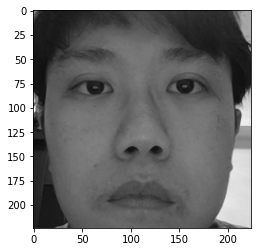

In [78]:
plt.imshow(face)

In [79]:
face

array([[[139, 139, 139],
        [144, 144, 144],
        [143, 143, 143],
        ...,
        [169, 169, 169],
        [167, 167, 167],
        [167, 167, 167]],

       [[132, 132, 132],
        [134, 134, 134],
        [137, 137, 137],
        ...,
        [168, 168, 168],
        [168, 168, 168],
        [168, 168, 168]],

       [[129, 129, 129],
        [131, 131, 131],
        [119, 119, 119],
        ...,
        [167, 167, 167],
        [167, 167, 167],
        [166, 166, 166]],

       ...,

       [[ 34,  34,  34],
        [ 33,  33,  33],
        [ 33,  33,  33],
        ...,
        [217, 217, 217],
        [217, 217, 217],
        [216, 216, 216]],

       [[ 33,  33,  33],
        [ 34,  34,  34],
        [ 34,  34,  34],
        ...,
        [216, 216, 216],
        [217, 217, 217],
        [215, 215, 215]],

       [[ 33,  33,  33],
        [ 34,  34,  34],
        [ 35,  35,  35],
        ...,
        [184, 184, 184],
        [202, 202, 202],
        [214, 214, 214]]

In [80]:
#1 Get Face Images and Face Labels from Resized_Faces for Face Training
def get_faces_labels(resized_images_path='Captured_Faces'):
    file_path = os.listdir(resized_images_path)
    faces = []
    face_labels = []
    current_id=0
    label_ids={}
    for file in file_path:
        if file.endswith("png") or file.endswith("jpg"):
            path=os.path.join(resized_images_path, file)
            label=os.path.basename(path).split(".")[1]
            #print(label,path)
            if not label in label_ids:
                #label_ids[label] = os.path.basename(path).split(".")[2]
                label_ids[label]=current_id
                current_id+=1

            id_=label_ids[label]
            pil_image=Image.open(path)#grayscale
            image_array=np.array(pil_image,'uint8')
                           
            #print(image_array)
            faces.append(image_array)
            face_labels.append(id_)
            faces_array = np.array(faces)
            labels_array = np.array(face_labels)
    return faces_array, labels_array, label_ids

In [82]:
a, b, c = get_faces_labels()
print(a.shape)
print(b)
print(c)

(40,)
[0 0 0 0 0 1 1 1 1 1 2 2 2 2 2 3 3 3 3 3 4 4 4 4 4 5 5 5 5 5 6 6 6 6 6 7 7
 7 7 7]
{'bryan_lee': 0, 'bryan_lim': 1, 'edmund': 2, 'malvern': 3, 'terren': 4, 'wangjue': 5, 'yicheng': 6, 'yirong': 7}


C:\Users\Yirong\miniconda3\envs\python36_vggface\lib\site-packages\ipykernel_launcher.py:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


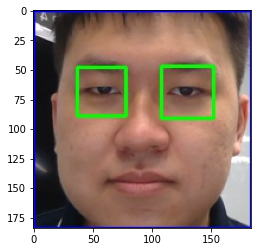

In [83]:
plt.imshow(a[0])

In [84]:
a[0]

array([[[  0,   6, 253],
        [  0,   6, 252],
        [  2,   1, 243],
        ...,
        [  1,   0, 244],
        [  0,   2, 247],
        [  0,   3, 249]],

       [[  0,   3, 251],
        [  0,   5, 238],
        [  4,   3, 205],
        ...,
        [ 15,  10, 198],
        [  2,   4, 211],
        [  2,   7, 223]],

       [[  2,   0, 251],
        [  9,   7, 214],
        [ 89,  85, 208],
        ...,
        [111, 103, 178],
        [110, 107, 240],
        [  8,   6, 167]],

       ...,

       [[  6,   0, 248],
        [ 10,   7, 202],
        [ 15,  15, 103],
        ...,
        [169, 173, 211],
        [181, 188, 255],
        [  5,  14, 155]],

       [[  0,   0, 250],
        [  5,   4, 219],
        [  9,   7, 150],
        ...,
        [ 66,  71, 175],
        [ 96, 104, 249],
        [  1,  13, 177]],

       [[  0,   0, 251],
        [  3,   5, 228],
        [ 10,   8, 179],
        ...,
        [ 11,  14, 153],
        [  3,  12, 175],
        [  4,  15, 191]]

# VGGFace 19/03/21

In [2]:
def get_faces_labels(resized_images_path='Color_Faces'):
    file_path = os.listdir(resized_images_path)
    faces = []
    face_labels = []
    current_id=0
    label_ids={}
    for file in file_path:
        if file.endswith("png") or file.endswith("jpg"):
            path=os.path.join(resized_images_path, file)
            label=os.path.basename(path).split(".")[1]
            #print(label,path)
            if not label in label_ids:
                #label_ids[label] = os.path.basename(path).split(".")[2]
                label_ids[label]=current_id
                current_id+=1

            id_=label_ids[label]
            pil_image=Image.open(path)#grayscale
            image_array=np.array(pil_image,'uint8')
                           
            #print(image_array)
            faces.append(image_array)
            face_labels.append(id_)
            faces_array = np.array(faces)
            labels_array = np.array(face_labels)
    return faces_array, labels_array, label_ids

In [3]:
face, label, label_dict = get_faces_labels()
print(face.shape)
print(label)
print(label_dict)

(15, 224, 224, 3)
[0 0 0 0 0 1 1 1 1 1 2 2 2 2 2]
{'peter': 0, 'wang_jue': 1, 'yirong': 2}


In [4]:
names = ['Peter', 'Wang_Jue', 'Yi_Rong']
name_list = []
for i in range(len(names)):
    for j in range(5):
        name = names[i]
        name_list.append(name)
name_array = np.array(name_list)
print(len(name_list))
print(name_array.shape)

15
(15,)


In [5]:
name_array

array(['Peter', 'Peter', 'Peter', 'Peter', 'Peter', 'Wang_Jue',
       'Wang_Jue', 'Wang_Jue', 'Wang_Jue', 'Wang_Jue', 'Yi_Rong',
       'Yi_Rong', 'Yi_Rong', 'Yi_Rong', 'Yi_Rong'], dtype='<U8')

In [18]:
with open('name_array.pickle', 'wb') as names:
    pickle.dump(name_array, names, protocol=pickle.HIGHEST_PROTOCOL)

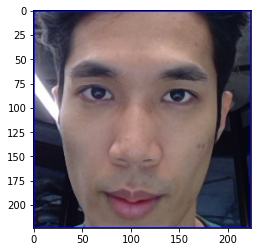

In [6]:
plt.imshow(face[0])

In [7]:
from keras.engine import  Model
from keras.layers import Flatten, Dense, Input
from keras_vggface.vggface import VGGFace

vgg_model = VGGFace(include_top=True, input_shape=(224, 224, 3))
last_layer = vgg_model.get_layer('fc8').output
custom_vgg_model = Model(vgg_model.input, last_layer)

custom_vgg_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)       0   

In [19]:
with open('vggface_model.pickle', 'wb') as vggface:
    pickle.dump(custom_vgg_model, vggface, protocol=pickle.HIGHEST_PROTOCOL)

In [20]:
with open('vggface_model.pickle', 'rb') as vggface1:
    custom_vgg_model1 = pickle.load(vggface1)
custom_vgg_model1.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)       0   

C:\Users\Yirong\miniconda3\envs\python36_vggface\lib\site-packages\keras\engine\saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [11]:
face_encoding = custom_vgg_model.predict(face)
print(face_encoding.shape)

(15, 2622)


In [15]:
with open('face_encoding.pickle', 'wb') as face_array:
    pickle.dump(face_encoding, face_array, protocol=pickle.HIGHEST_PROTOCOL)

In [16]:
with open('face_encoding.pickle', 'rb') as face_array1:
    face_encoding1 = pickle.load(face_array1)

In [17]:
face_encoding1.shape

(15, 2622)

In [9]:
def dimension_reduction(face_encoding, n=15, m=100):
    # Compute covariance matrix, return shape (2622, 2622)
    covariance = np.dot(face_encoding.T, face_encoding) / n
    print("covariance matrix shape (2622, 2622): ", covariance.shape)
    total_features = face_encoding.shape[1] # 2622 features
    print("Calculaing top eigenvalues and corresponding eigenvectors...")
    # Compute eigenval and eigenvec, return shape (1, m) and (2622, m)
    eigenvalues, eigenvectors = linalg.eigh(covariance, eigvals=(total_features-m,total_features-1))
    print("eigenvalues shape (m,): ", eigenvalues.shape)
    print("eigenvectors shape (2622, m): ", eigenvectors.shape)
    print("Eigens Computation Done!")
    # Compute eigenfaces, return shape (m, 2622)
    eigenfaces = eigenvectors.T
    print("eigenface shape (m,2622)", eigenfaces.shape)
    # Project zero mean faces into eigen space for training, return shape (15, m)
    face_train = np.dot(face_encoding, eigenvectors)
    print("face_train (15,m): ", face_train.shape)
    return eigenvalues, eigenvectors, eigenfaces, face_train, covariance

In [12]:
_, eigenvector, _, face_train, _ = dimension_reduction(face_encoding)
print('##########################')
print(eigenvector.shape)
print(face_train.shape)

covariance matrix shape (2622, 2622):  (2622, 2622)
Calculaing top eigenvalues and corresponding eigenvectors...
eigenvalues shape (m,):  (100,)
eigenvectors shape (2622, m):  (2622, 100)
Eigens Computation Done!
eigenface shape (m,2622) (100, 2622)
face_train (15,m):  (15, 100)
##########################
(2622, 100)
(15, 100)


In [10]:
def findCosineSimilarity(source, test):
    a = np.matmul(np.transpose(source), test)
    b = np.sum(np.multiply(source, source))
    c = np.sum(np.multiply(test, test))
    return 1 - (a / (np.sqrt(b) * np.sqrt(c)))

In [13]:
def vgg_face_recognition(name_array, face_train, eigenvector):
    faceCascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml') # load classifier
    eye_glassesCascade = cv2.CascadeClassifier('haarcascade_eye_tree_eyeglasses.xml')

    cap = cv2.VideoCapture(0)

    cap.set(3,1280) # set Width
    cap.set(4,960) # set Height
    while True:
        _, frame = cap.read()
        frame = cv2.flip(frame, 1)
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # detect faces
        faces = faceCascade.detectMultiScale(
            gray,     
            scaleFactor=1.2,
            minNeighbors=5,     
            minSize=(5, 5)
        )
        for (x,y,w,h) in faces:
            cv2.rectangle(frame,(x,y),(x+w,y+h),(255,0,0),2)
            roi_color = frame[y:y+h, x:x+w]
            roi_gray = gray[y:y+h, x:x+w]
            resized_color = cv2.resize(frame[y:y+h,x:x+w], dsize=(224,224), interpolation=cv2.INTER_AREA)
            eyes = eye_glassesCascade.detectMultiScale(roi_gray, scaleFactor=1.2, minNeighbors=5, minSize=(5,5))
            for (ex, ey, ew, eh) in eyes:
                cv2.rectangle(roi_color, (ex, ey), (ex + ew, ey + eh), (0, 255, 0), 2)
    #         smile = smileCascade.detectMultiScale(roi_gray, scaleFactor=1.2, minNeighbors=25, minSize=(120,120))
    #         for (xx, yy, ww, hh) in smile:
    #             cv2.rectangle(roi_color, (xx, yy), (xx + ww, yy + hh), (0, 0, 255), 2)
            rgb_face_resize = np.reshape(resized_color, (1,224,224,3))
            y_pred = custom_vgg_model.predict(rgb_face_resize) # 1x2622
            captured_representation = np.dot(y_pred, eigenvector) # 1x100
            
            
            found=0
            min_value=1
            for i in range(len(name_array)):
                similarity = findCosineSimilarity(face_train[i], captured_representation.T)
                if((similarity < 0.1) & (similarity < min_value)):
                    min_value = similarity
                    name = name_array[i]
                    found=1
            if (found==1):
                #cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 0, 0), 2)
                cv2.putText(frame, name, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)
                #cv2.putText(frame, name, (int(x+w), int(y-30)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2)
                print(name, min_value)
            
                    
            elif (found==0):
                cv2.putText(frame, 'Unknown', (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)
                print('Unknown', similarity)
                
        cv2.imshow('frame',frame)
        k = cv2.waitKey(10) & 0xff
        if k == 27: # press 'ESC' to quit
            break
    cap.release()
    cv2.destroyAllWindows()
    return

In [14]:
vgg_face_recognition(name_array, face_train, eigenvector)

Yi_Rong [0.0155775]
Yi_Rong [0.01159656]
Unknown [0.23361504]
Unknown [0.13765943]
Unknown [0.17815119]
Yi_Rong [0.0116452]
Yi_Rong [0.0155353]
Yi_Rong [0.02215236]
Yi_Rong [0.02378577]
Yi_Rong [0.02380282]
Yi_Rong [0.03312582]
Yi_Rong [0.02520633]
Yi_Rong [0.023467]
Yi_Rong [0.02522832]
Yi_Rong [0.02540457]
Yi_Rong [0.01885253]
Yi_Rong [0.01744574]
Yi_Rong [0.032278]
Yi_Rong [0.03546083]
Yi_Rong [0.0411551]
Yi_Rong [0.030038]
Yi_Rong [0.03713065]
Yi_Rong [0.03248465]
Yi_Rong [0.03346306]
Yi_Rong [0.03374434]
Yi_Rong [0.03614247]
Yi_Rong [0.03250593]
Yi_Rong [0.03134423]
Yi_Rong [0.03057575]
Yi_Rong [0.03282565]
Yi_Rong [0.02060175]
Yi_Rong [0.01458776]
Unknown [0.20149153]
Wang_Jue [0.04318625]
Wang_Jue [0.02273178]
Wang_Jue [0.01110387]
Wang_Jue [0.01742119]
Wang_Jue [0.01648962]
Wang_Jue [0.01098448]
Wang_Jue [0.01496404]
Wang_Jue [0.01955521]
Wang_Jue [0.03276712]
Wang_Jue [0.02442843]
Wang_Jue [0.02356505]
Wang_Jue [0.06440622]
Wang_Jue [0.03133893]
Wang_Jue [0.03405428]
Wang_Jue 

In [52]:
min_value = 1
for i in range(len(name_array)):
    name = name_array[i]
    similarity = findCosineSimilarity(d[i], face_test.T)
    print(similarity)

[0.17447567]
[0.18407154]
[0.22283965]
[0.29063225]
[0.20811933]
[0.14004725]
[0.148458]
[0.16595906]
[0.15751845]
[0.1686889]
[0.09243411]
[0.05366927]
[0.06377923]
[0.15563858]
[0.14338273]
